In [35]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import extcolors
import skimage
import scipy
from PIL import Image
import math
import skimage
from sklearn.linear_model import LinearRegression
import pandas as pd
from colormap import rgb2hex
import numpy as np
import cv2
import os


VID = 0
SING_IMG = 1
nb_row = 4

# READ AND NORMALIZE IMAGES
def obtain_name_images(image_folder):
    """
    input : name of the folder with the images
    output : name of the files to be open
    """
    lst = os.listdir(image_folder)
    lst.sort()
    name_images = [img for img in lst 
                if img.endswith(".jpg") or
                    img.endswith(".jpeg") or
                    img.endswith(".JPG") or
                    img.endswith("png")]

    return name_images 

def obtain_images(name_images, image_folder, mode):
    """
    input : name and foler of the images location
    returns : list containing all the images in the folder in RGB format
    """
    imgs = []
    if mode == VID : 
        for name in name_images:
            img = cv2.imread(os.path.join(image_folder, name))
            if img is not None : 
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_small = img_resize(img_rgb)
                imgs.append(img_small)

    if mode == SING_IMG :
        print('image read : ', os.path.join(image_folder, name_images))
        img = cv2.imread(os.path.join(image_folder, name_images))
        if img is not None : 
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_small = img_resize(img_rgb)
            imgs.append(img_small)
        else : 
            print('no image read')

    if (len(imgs) != 0) : 
        return imgs #return rgb img
    
    return None

def img_resize(img, output_width = 500):
    """
    input : image
    output : resized image
    """
    wpercent = (output_width/float(img.shape[1]))
    hsize = int((float(img.shape[0])*float(wpercent)))
    img = cv2.resize(img, (output_width,hsize), interpolation = cv2.INTER_AREA) 
    #this resize makes the video not work??
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def colors_to_array(colors_x) : 
    """
    input : tuple containing list of the main colors cluster of the images
    output : 2 np array containg the cluster color in rgb and lab space
    """
    colors_rgb = np.zeros((len(colors_x[0]),3))
    colors_lab = np.zeros((len(colors_x[0]),3))

    for i in range(len(colors_x[0])):
        col = colors_x[0][i][0]
        colors_rgb[i] = col
        colors_lab[i] = skimage.color.rgb2lab((col[0]/255, col[1]/255, col[2]/255))

    return colors_rgb, colors_lab

def donuts(colors_x): 
    """
    input : tuple containing list of the main colors cluster of the images and their occurence
    output : plt figure reprensenting the main colors anf their proportions
    """
    colors_pre_list = str(colors_x).replace('([(','').split(', (')[0:-1]
    df_rgb = [i.split('), ')[0] + ')' for i in colors_pre_list]
    df_percent = [i.split('), ')[1].replace(')','') for i in colors_pre_list]
    
    #convert RGB to HEX code
    df_color_up = [rgb2hex(int(i.split(", ")[0].replace("(","")),
                          int(i.split(", ")[1]),
                          int(i.split(", ")[2].replace(")",""))) for i in df_rgb]
    
    df_color = pd.DataFrame(zip(df_color_up, df_percent), columns = ['c_code','occurence'])
    list_color = list(df_color['c_code'])
    list_precent = [int(i) for i in list(df_color['occurence'])]
    text_c = [c + ' ' + str(round(p*100/sum(list_precent),1)) +'%' 
            for c, p in zip  (list_color, list_precent)]
    fig, ax = plt.subplots(figsize=(50,50),dpi=10)
    wedges, text = ax.pie(list_precent,
                        labels= text_c,
                        labeldistance= 1.05,
                        colors = list_color,
                        textprops={'fontsize': 120, 'color':'black'}
                        )
    plt.setp(wedges, width=0.3)

    #create space in the center
    plt.setp(wedges, width=0.36)

    ax.set_aspect("equal")
    fig.set_facecolor('white')
    plt.show()  

def extract_rgb_colors(img):
    """
    input : rgb image as np array
    output : list of main rgb colors 
    """
    # extract the main colors from the image 
    im_pil = Image.fromarray(img)
    colors_x = extcolors.extract_from_image(im_pil, tolerance = 12, limit = 8) 
    colors_rgb, colors_lab = colors_to_array(colors_x)
    #donuts(colors_x)# for debugging 

    return colors_rgb

def greenest_color(colors_rgb):
    """
    input : list of rgb colors
    output : greenest color in rgb format
    """
    diff = smallest_diff = float('inf')

    for col in colors_rgb:
        # calculate the difference to the green
        diff = np.linalg.norm(np.asarray(col - [0,255,0])) # maybe better to use lab format?
        if diff < smallest_diff: # if closest to green
            smallest_diff =diff
            col_best_mask = col
    col_best_mask = col_best_mask.astype(int)
    r,g,b = (col_best_mask.data)
    
    print('the best color is : rgb ', col_best_mask, 'hex : ', rgb2hex(r,g,b))

    return col_best_mask

def mask_vegetation(img_lab, col_lab):
    """
    input : 
    output :
    """
    # Using inRange method, to create a mask
    thr = [8,8,8] # before : 8 20 8 , TODO : maybe change  thr according to histogram ??
    lower_col = col_lab - thr
    upper_col = col_lab + thr
    mask = cv2.inRange(img_lab, lower_col, upper_col)
    return mask

def veg_segmentation(img, img_no_sky):

    # extract the main colors from the image 
    colors_rgb = extract_rgb_colors(img)

    # extract greenest color 
    col_best_mask = greenest_color(colors_rgb)

    # convert color and image to lab space
    img_lab = skimage.color.rgb2lab(img_no_sky/255)
    col_best_mask_lab = skimage.color.rgb2lab((col_best_mask[0]/255, col_best_mask[1]/255, col_best_mask[2]/255))

    # vegetation segmentation using mask of the detected vegetal color
    best_mask = mask_vegetation(img_lab, col_best_mask_lab)
    best_mask_median = cv2.medianBlur(best_mask,3)
    
    return best_mask_median, col_best_mask

def hough_line_improved(mask, angle_acc):
    """
    input : 2D mask + list containing the angle previously found
    output : accumulator + array to convert theta and rhos to accumulator coordinates
    """
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(0, 180))
    width, height = mask.shape
    diag_len = int(np.ceil(np.sqrt(width * width + height * height)))   # max_dist
    rhos = np.linspace(-diag_len, diag_len, num = diag_len * 2)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(mask)  # (row, col) indexes to edges
    #print(y_idxs, x_idxs)

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        #print('step ', i, 'of len ', len(x_idxs))
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = round(x * cos_t[t_idx] + y * sin_t[t_idx]) + diag_len
            accumulator[rho, t_idx] += 1
            if (abs(np.rad2deg(thetas[t_idx])-90)<20): #if horizontale lignes 
                accumulator[:, t_idx] = 0
            
            for angle in angle_acc:
                if (abs(np.rad2deg(thetas[t_idx])-np.rad2deg(angle))<10): #if angle already detected 
                    accumulator[:, t_idx] = 0


    return accumulator, thetas, rhos

def keep_mask_max_acc_lines(best_mask_edge, img_no_sky, crop_nb):
    """
    input : mask where we want to use HT, img to draw on it, 
            nb_of crops we want to detect
    output : new mask for next image, list of theta and r detected, 
            threshold_acc, best_mask_evaluate = img with lines drawned
    """

    best_mask_edge_copy = np.copy(best_mask_edge)
    best_mask_evaluate = np.copy(img_no_sky)
    img_no_sky_copy = np.copy(img_no_sky)
    band_width = int(img_no_sky.shape[1]/25)

    #crop_nb = 3

    th_acc = []
    r_acc = []
    threshold_acc = []
    mask = []
    pts1 = []

    for i in range(crop_nb):
        mask_single_crop = np.zeros_like(best_mask_edge)

        print('step ', (i+1), 'of ', crop_nb)
        acc, thetas, rhos = hough_line_improved(best_mask_edge_copy, th_acc)

        th_max = acc.max()

        r_idx, th_idx = np.where(acc>=th_max)
        r = rhos[r_idx[0]]#in case multiple same max 
        th = thetas[th_idx[0]]

        th_acc.append(th)
        r_acc.append(r)
        threshold_acc.append(th_max)

        a = math.cos(th)
        b = math.sin(th)
        x0 = a * r
        y0 = b * r
        print('pt detected : ', x0,y0) #x0=27, y0 = 64 -->on veut x0 = height of image 
        coeff_1 = (mask_single_crop.shape[0]-y0)/a
        #new_pt = (x0, mask_single_crop.shape[0])
        p1 = (int(x0 + coeff_1*(-b)), int(y0 + coeff_1*(a)))
        print('p1 : ', p1)
        pts1.append(p1)
        coeff_2 = (y0/a)
        p2 = (int(x0 - coeff_2*(-b)), int(y0 - coeff_2*(a)))
        print('p2 : ', p2)

        cv2.line(best_mask_edge_copy, p1, p2, (0,0,0), band_width)
        cv2.line(best_mask_evaluate, p1, p2, (255,0,0), 3)
        cv2.circle(best_mask_evaluate, p1, 10, (255,255,255), 5)

        cv2.line(img_no_sky_copy, p1, p2, (255,0,0), 3)
        cv2.line(mask_single_crop, p1, p2, (255,0,0), band_width)
        mask.append(mask_single_crop)

    return mask, th_acc, r_acc, threshold_acc, best_mask_evaluate, pts1

def VP_detection(th_acc, r_acc, threshold_acc,img_no_sky_copy ): 
    #VP detection 
    #ADD COND THAT INTERSEECTON MUST BE IN A RADIUS TO AVOID OUTLIERS 
    # => or KMEAN with K = 2?

    A = B = C = D = E = 0

    for t,r,w in zip(th_acc, r_acc, threshold_acc):
        a = np.cos(t)
        b = np.sin(t)
        A = A + w*pow(a,2)
        B = B + w*pow(b,2)
        C = C + w*a*b
        D = D + w*a*r
        E = E + w*b*r

    M = np.array([[A,C],[C,B]])
    #print(np.linalg.det(M))
    b = np.array([D,E])
    x0,y0 = np.linalg.solve(M,b).astype(int)

    cv2.circle(img_no_sky_copy, (x0, y0), 10, (255,255,255), 5)
    #cv2.imshow('VP drawned : ', img_no_sky_copy)
    #cv2.waitKey(1000)

    print('VP is : ', x0, y0)

    return x0,y0

def apply_ransac(img_no_sky, masked_images_i, vp_point, vp_on, best_mask, arr_mask_i, i):

    mask_single_crop = np.zeros_like(img_no_sky)
    x,y = np.where(masked_images_i>0)
    data = np.column_stack([x, y])
    if(vp_on>0):
        vp_point = np.asarray(vp_point)
        n = int(data.shape[0])
        vp_data_x = np.full((n,1), vp_point[1])
        vp_data_y = np.full((n,1), vp_point[0])
        data_vp = np.column_stack([vp_data_x, vp_data_y])
        data = np.row_stack([data, data_vp])

    #print('data : ', data.size)
    #if (data.size<10):
        #cv2.waitKey(20000)


    if(data.shape[0]>700):
        data = data[np.random.choice(data.shape[0], 600, replace=False), :]

    #put condition, if data to small, go to initial process!
    if(data.shape[0]<100):
        print(' mask that has no data : ', i)
        print(data.shape)
        cv2.imshow('masked image i', masked_images_i)
        cv2.imshow('best_mask', best_mask)
        cv2.imshow('arr_mask_i', arr_mask_i)


        cv2.waitKey(0)
        cv2.destroyAllWindows()


    if (1) : #(data.shape>10):
        model, inliers = skimage.measure.ransac(data, skimage.measure.LineModelND, min_samples=2, residual_threshold=1, max_trials=1000)
        temp = np.copy(masked_images_i)
        y0, x0 = model.params[0]#.astype(int)
        t1, t0 = model.params[1]
        m = t1/t0
        #print(m)
        #ADD CONDITION ON M
        x2 = (x0 + 500)
        y2 = (y0 + 500*m)
        x1 = (x0 - 500)
        y1 = (y0 - 500*m)
        p1 = [int(x1),int(y1)]
        p2 = [int(x2),int(y2)]
    else : 
        p1 = [0,0]
        p2 = [0, 1]
        m  = 0
    return p1, p2, m

def remove_double(p1, p2, m, acc_m, masked_image, wd):
    cond_double = 0
    #print('in')
    #print(acc_m)
    if (len(acc_m)>=1):

        for m_others in acc_m:
            #print('diff m', m - m_others)

            if (abs(m-m_others)<0.1): #if angle already detected 
                #print('diff m', m - m_others)

                cv2.line(masked_image, p1, p2, (0,0,0), wd)
                cond_double = 0
                #print('diff : ', m, m_others)
            
            else : #pas une bonne idée : une crop pourrait en remplacer une autre 
                cond_double = 1
    else : 
        cond_double = 1

    return masked_image, cond_double

def remove_horizon(p1, p2, m, masked_image, bw):
    thr = 0.1
    cond_horizon = 0

    if (abs(m)<thr):
        cv2.line(masked_image, p1, p2, (0,0,0), bw)
        #print('horizon detected', m)

    if (abs(m)>=thr):
        cond_horizon = 1

    return masked_image, cond_horizon

def squared_distance_to_line(point, line_point1, line_point2):
    # Convert the points to numpy arrays for easier calculations
    point = np.array(point)
    line_point1 = np.array(line_point1)
    line_point2 = np.array(line_point2)

    # Calculate the direction vector of the line
    line_dir = line_point2 - line_point1

    # Calculate the normal vector of the line
    line_normal = np.array([line_dir[1], -line_dir[0]])

    # Calculate the squared distance from the point to the line by taking the dot product of the normal vector
    # with the vector pointing from the line to the point, and then dividing by the square of the length of the normal vector
    return np.dot(line_normal, point - line_point1)**2 / np.dot(line_normal, line_normal)

def pattern_ransac(arr_mask, vp_point, img, max_iterations=100, threshold=2000):

    model = None 
    nb_cr = len(arr_mask)
    data = np.zeros(((nb_cr+1),2)) #+1 for the VP point 
    best_nb_inliers = 0

    for it in range(max_iterations):
        if (it%10==0):
            print('iteration ', it, ' out of ', max_iterations)
        
        list_cr_lines = []

        rand_vp = [vp_point[0] + np.random.randint(-10,10), vp_point[1] + np.random.randint(-10, 10)]

        #first randomly select data 
        data[nb_cr] = rand_vp
        for i in range(nb_cr): #select randomlw one point from each mask

            row = cv2.bitwise_and(img, arr_mask[i])
            y,x = np.where(row>0)
            rand_nb = np.random.randint(0, len(x)-1)
            data[i] = [x[rand_nb], y[rand_nb]]
            pt1 = (rand_vp[0], rand_vp[1])
            pt2 = (x[rand_nb], y[rand_nb])
            list_cr_lines.append([pt1, pt2])

        nb_inliers = 0

        
        #calculate error 
        for i in range(nb_cr):
            row = cv2.bitwise_and(img, arr_mask[i])
            x,y = np.where(row>0)
            [p1,p2] = np.array(list_cr_lines[i])

            for x_x, y_y in zip(x,y):
                p3 = np.array(x_x,y_y)
                err = squared_distance_to_line(p3, p1, p2)
                print(err)

                if abs(err)<threshold:
                    nb_inliers = nb_inliers + 1
        

        if nb_inliers>best_nb_inliers:
            print('new best nb inliers : ', best_nb_inliers)
            best_nb_inliers = nb_inliers
            model = list_cr_lines
    
    print('nb inliers : ', nb_inliers, 'out of ', nb_cr * len(x))
    
    return model

def speed_process_lines(image, col_best_mask, arr_mask, vp_pt):

    img_lab = skimage.color.rgb2lab(image/255) #calculate best color mask based on previously calculated color 
    col_best_mask_lab = skimage.color.rgb2lab((col_best_mask[0]/255, col_best_mask[1]/255, col_best_mask[2]/255))

    best_mask = mask_vegetation(img_lab, col_best_mask_lab)
    #plt.imshow(mask_col)
    band_width = int(image.shape[1]/25)
    #print('bw : ', band_width)
    

    # mask_col_edge = cv2.Canny(mask_col,100,200) #add la cond sur le laplacien 

    pts1 = []
    pts2 = []
    acc_m = []
    masked_images = []
    img_ransac_lines = np.copy(image)
    #cr = np.zeros_like(best_mask)
    arr_mask_new = []

    
    for i in range(len(arr_mask)):
        masked_images.append(cv2.bitwise_and(best_mask, arr_mask[i]))
        cv2.imshow('masked image of i :', masked_images[i])
        cv2.waitKey(0)

    
    for i in range(len(arr_mask)): #for each row
        mask_single_crop = np.zeros_like(best_mask)
        cond = m = cond_horizon = cond_double = 0


        """
        p1 = [0, 100]
        p2 = [100, 0]
        m=0"""

        #p1, p2, m = apply_ransac(image, masked_images[i], vp_pt, 0)

        
        while(cond_horizon*cond_double == 0 ): 
            p1, p2, m = apply_ransac(image, masked_images[i], vp_pt, 0, best_mask, arr_mask[i], i)
            masked_images[i], cond_horizon = remove_horizon(p1, p2, m, masked_images[i], band_width)
            masked_images[i], cond_double = remove_double(p1, p2, m, acc_m, masked_images[i], band_width)
            #cond_horizon, cond_double = check_ransac_cond(p1,p2,m, acc_m)
            if (cond_horizon*cond_double==0):
                print('still not met')
                #cv2.imshow('new with still bad cond : ', masked_images[i])
        
    
        pts1.append(p1)
        pts2.append(p2)
        acc_m.append(m)
        cv2.line(img_ransac_lines, p1, p2, (255,0,0), 1)
        #cv2.line(cr, p1, p2, (255,0,0), 1)
        cv2.line(mask_single_crop, p1, p2, (255,0,0), band_width)
        arr_mask_new.append(mask_single_crop)

    #TODO : put back : vp_pt = intersect_multiple_lines(pts1, pts2)

    #cv2.imshow('ransac lines : ', img_ransac_lines)
    
    

    return arr_mask_new, img_ransac_lines, vp_pt

def intersect_multiple_lines(pts1,pts2):
    """P0 and P1 are NxD arrays defining N lines.
    D is the dimension of the space. This function 
    returns the least squares intersection of the N
    lines from the system given by eq. 13 in 
    http://cal.cs.illinois.edu/~johannes/research/LS_line_intersect.pdf.
    """
    P0 = np.asarray(pts1)
    P1 = np.asarray(pts2)

    # generate all line direction vectors 
    n = (P1-P0)/np.linalg.norm(P1-P0,axis=1)[:,np.newaxis] # normalized

    # generate the array of all projectors 
    projs = np.eye(n.shape[1]) - n[:,:,np.newaxis]*n[:,np.newaxis]  # I - n*n.T
    
    # generate R matrix and q vector
    R = projs.sum(axis=0)
    q = (projs @ P0[:,:,np.newaxis]).sum(axis=0)

    # solve the least squares problem for the 
    # intersection point p: Rp = q
    p = np.linalg.lstsq(R,q,rcond=None)[0]

    return(p)

def cal_skyline(mask):
    h, w = mask.shape
    for i in range(w): #for each column
        raw = mask[:, i]
        after_median = scipy.signal.medfilt(raw, 19)
        try:
            first_zero_index = np.where(after_median == 0)[0][0]
            first_one_index = np.where(after_median == 1)[0][0]
            if first_zero_index > 20: #if the sky is bigger then 20 px starting from the top
                mask[first_one_index:first_zero_index, i] = 1 #put 1 between sky and land
                mask[first_zero_index:, i] = 0 #put 0 in land (appears black)
                mask[:first_one_index, i] = 0 #put 0 before the sky starts 
        except:
            continue
    return mask

def get_sky_region_gradient(img):
    h, w, _ = img.shape
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.blur(img_gray, (9, 3))
    img_gray= cv2.medianBlur(img_gray, 5)
    lap = cv2.Laplacian(img_gray, cv2.CV_8U)
    gradient_mask = (lap < 6).astype(np.uint8) # we keep region with small laplacian ->sky
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
    mask = cv2.morphologyEx(gradient_mask, cv2.MORPH_ERODE, kernel) #erosion that takes the minimum of neighbouring px
    mask_sky = cal_skyline(mask)
    after_img = cv2.bitwise_and(img, img, mask=mask_sky)
    return after_img

def cut_image_from_mask(grad_sky,img):
    #Cut from the top until less then 60% of sky is detected

    low = np.array([1,1,1])
    high = np.array([256,256,256])
    masked_sky = cv2.inRange(grad_sky, low, high)
    h,w = masked_sky.shape
    i = h
    count = flag = j = 0
    img_new = img
    while((i>0) & (flag==0)):
        i=i-1 
        j = count = 0
        while(j<w):
            if (masked_sky[i,j] == 255) : # if px is sky 
                count = count + 1
            j=j+1
            if (count > (w*0.3)): #cut until 30% of the line isn't sky
                lim = i; 
                flag = 1

    img_new = img[lim:,:,:]


    #cv2.imshow('Image with Sky cut out', cv2.cvtColor(img_new, cv2.COLOR_BGR2RGB))
    #cv2.waitKey(2000)
    
    return img_new



In [38]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import extcolors
import skimage
import scipy
from PIL import Image
import math
import skimage
from sklearn.linear_model import LinearRegression
import pandas as pd
from colormap import rgb2hex
import numpy as np
import cv2
import os
import MaskingProcess


def Initial_Process(img, nb_row = 4, sky = 0):

    #Cut off sky
    if(sky==1) : 
        grad_sky = MaskingProcess.get_sky_region_gradient(img)
        img_no_sky = MaskingProcess.cut_image_from_mask(grad_sky, img)
    else : 
        img_no_sky = img

    best_mask_median, col_best_mask = MaskingProcess.veg_segmentation(img, img_no_sky)
    best_mask_median_edge = cv2.Canny(best_mask_median,100,200)

    arr_mask, th_acc, r_acc, threshold_acc, best_mask_evaluate, pts_bottum = keep_mask_max_acc_lines(best_mask_median_edge, img_no_sky, nb_row)

    vp_pt = np.asarray(MaskingProcess.VP_detection(th_acc, r_acc, threshold_acc, best_mask_median_edge))

    #cv2.imshow('after initial process', best_mask_evaluate)
    #cv2.waitKey(0)

    arr_mask = check_equidistance(arr_mask)

    return best_mask_evaluate, arr_mask, col_best_mask, vp_pt, pts_bottum

def Speed_Process(img, arr_mask, col_best_mask, vp_pt, nb_row = 4,  sky_on = 0):

    annotated_img = np.copy(img)
    img_lab = skimage.color.rgb2lab(img/255)

    col_best_mask_lab = skimage.color.rgb2lab((col_best_mask[0]/255, col_best_mask[1]/255, col_best_mask[2]/255))
    
    # vegetation segmentation using mask of the detected vegetal color
    best_mask = MaskingProcess.mask_vegetation(img_lab, col_best_mask_lab)
    best_mask_median = cv2.medianBlur(best_mask,3)

    #cv2.imshow('best_mask_median', best_mask_median)
    #cv2.waitKey(1000)

    #print(best_mask_median.shape)
    model = MaskingProcess.pattern_ransac(arr_mask, vp_pt, best_mask_median) 


    for crop in model:
        crop = np.asarray(crop)
        diff = (crop[1]-crop[0])
        cv2.line(annotated_img, crop[0], crop[1]+5*diff, (50,200,50), 3)


    cv2.line(annotated_img, (10,100), (100,10), (255,0,0), 10)
    cv2.line(annotated_img, (100,10), (10,100), (0,255,0), 5)
    cv2.line(annotated_img, (10,10), (100,100), (0,0,255), 2)

    return annotated_img, arr_mask



In [5]:
import numpy as np

In [9]:
Array = np.array([[1,2,3,5,5],[1,3,4,5,7],[8,9,7,6,5],[9,7,6,5,4],[1,1,1,2,3]])

In [11]:
Array

array([[1, 2, 3, 5, 5],
       [1, 3, 4, 5, 7],
       [8, 9, 7, 6, 5],
       [9, 7, 6, 5, 4],
       [1, 1, 1, 2, 3]])

In [13]:
a = np.zeros((4,11))
for i in range(6):
    #print(i)
    a[0,5+i] = 1
    a[0,5-i] = 1
print(a)



[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [13]:
Array[:,1::2]

array([[2, 5],
       [3, 5],
       [9, 6],
       [7, 5],
       [1, 2]])

In [65]:
import numpy as np
import cv2
import PerImageProcessing
import MaskingProcess
import Evaluation


VID = 0
SING_IMG = 1
INI_PROCESS = 0
SPEED_PROCESS = 1
FINAL_PROCESS = 2

mode = VID
nb_row = 5
        

In [66]:
sky_on = 1

imgs_folder = '/home/roxane/Desktop/M3_2022/USB/Realsense_18-08-2022_10-46-58/'
name_images = MaskingProcess.obtain_name_images(imgs_folder)
#open and resize images for consistency --> returns img in rgb format
images = MaskingProcess.obtain_images(name_images,imgs_folder, mode)



initial process...
the best color is : rgb  [109  93  53] hex :  #6D5D35
step  1 of  5
pt detected :  46.12413145152914 -90.52370494407164
p1 :  (524, 153)
p2 :  (223, 0)
step  2 of  5
pt detected :  103.69027372463667 103.69027372463665
p1 :  (54, 153)
p2 :  (207, 0)
step  3 of  5
pt detected :  27.572904888214847 64.95769321353428
p1 :  (-179, 153)
p2 :  (180, 0)
step  4 of  5
pt detected :  96.59511509520607 -103.5855789693319
p1 :  (371, 153)
p2 :  (207, 0)
step  5 of  5
pt detected :  203.16992311879454 24.94612979881807
p1 :  (187, 153)
p2 :  (206, 0)
VP is :  207 -6
(153, 500)


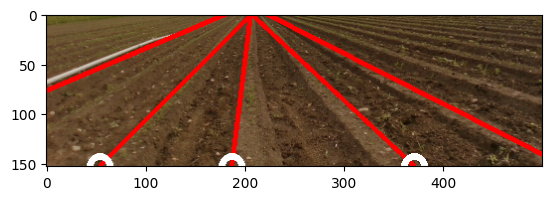

In [68]:
imgs_annotated = []
stage = INI_PROCESS

if stage == INI_PROCESS: #longer but needed to create initial mask of images 
    print('initial process...')
    hough_img, arr_mask, col_best_mask, vp_pt, pts1 = Initial_Process(images[0], nb_row = 5, sky = 1)
    height_original = images[0].shape[0]
    height, _, = arr_mask[0].shape
    print(arr_mask[0].shape)
    
    #cv2.imshow('hough image :  :q ', cv2.cvtColor(hough_img, cv2.COLOR_RGB2BGR))
    #cv2.waitKey(0)
    #if cv2.waitKey(1) == ord('q'):
        #cv2.destroyAllWindows() 
    
    plt.imshow(hough_img)


In [69]:
news_points = pts1
dist = []
news_points.sort()
print(news_points[1])
for i in range(len(news_points)-1):
    d = (news_points[i][0]-news_points[i+1][0])
    dist.append(d)

dist = np.asarray(dist)
mean = dist.mean()
median = np.median(dist)


print(dist)
print(mean, median)

for i in range(dist.shape[0]):
    print(dist[i], (mean))
    if abs(dist[i])>(1.6*abs(mean)):
        print('pb with crop', i, 'and crop', i+1, 'too far')
    if abs(dist[i])<(0.7*abs(mean)):
        print('pb with crop', i, 'and crop', i+1, 'too close')
    if abs(dist[i])>(1.6*abs(median)):
        print('pb with crop', i, 'and crop', i+1, 'too far')
    if abs(dist[i])<(0.7*abs(median)):
        print('pb with crop', i, 'and crop', i+1, 'too close')

(54, 153)
[-233 -133 -184 -153]
-175.75 -168.5
-233 -175.75
-133 -175.75
-184 -175.75
-153 -175.75


In [70]:
cv2.imshow('hough image : ', hough_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
stage = SPEED_PROCESS

if stage == SPEED_PROCESS: #quick, use of ransac 
    print('...speed process...')
    for idx, img in enumerate(images):
        #print(idx, 'vp : ', vp_pt)
        img = img[height_original-height:,:,:]
        
        
        arr_mask, img_annotated, vp_pt = MaskingProcess.speed_process_lines(img, col_best_mask, arr_mask, vp_pt)
        
        #img_annotated = img
        #vp point to recaulculate 
        # img_annotated, arr_mask = PerImageProcessing.Speed_Process(img, arr_mask, col_best_mask, vp_pt)
        imgs_annotated.append(img_annotated)
        
        if(mode ==VID): 
            cv2.imshow('vid :q ', cv2.cvtColor(img_annotated, cv2.COLOR_RGB2BGR))
            #cv2.imshow('no annotation', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

            if cv2.waitKey(1) == ord('q'):
                cv2.destroyAllWindows() 
                break   
        
        stage = FINAL_PROCESS

In [ ]:
def check_equidistance(arr_mask):

    
    return arr_mask

In [ ]:


def detection_process(images, mode, nb_row = 6, sky = 1):
    """
    input : list of img to be analyzed in rgb format
    output : not yet defined, prob data + flag set to one if analyzing went smoothly 
    """


    

    if stage == FINAL_PROCESS : #save data and evaluate it 
        print('...processing done!')
        data = Evaluation.SaveData(imgs_annotated)
        #TODO:implement evaluation 
        if(mode ==SING_IMG):
            cv2.imshow('img : ', cv2.cvtColor(img_annotated, cv2.COLOR_RGB2BGR))
            cv2.waitKey(0)
            if cv2.waitKey(1) == ord('q'):
                cv2.destroyAllWindows() 

    return data #return something en rapport avec le bon acheminement du process


In [2]:
import cv2

In [3]:
GroundTruthLink = '/home/roxane/Desktop/M3_2022/crop_dataset_annoted/GT data/crop_row_001.crp' #replace by name_images[0]
imagePath = '/home/roxane/Desktop/M3_2022/Caterra/dataset_straigt_lines/'
imageHeight = 240
imageWidth = 320
halfWidth = imageWidth/2;
GTImage = cv2.imread(os.path.join(imagePath, name_images[0]))

NameError: name 'name_images' is not defined

In [24]:
pts1 = np.asarray([(-582, -832), (-391, -938), (-63, 1011), (-822, -583), (-2, -1018), (-406, 922), (-672, 744), (-801, 630)])
pts2 = np.asarray([(832, 582), (697, 739), (386, -937), (943, 355), (379, 945), (623, -791), (789, -619), (980, -277)])


In [33]:
pts1

array([[ -582,  -832],
       [ -391,  -938],
       [  -63,  1011],
       [ -822,  -583],
       [   -2, -1018],
       [ -406,   922],
       [ -672,   744],
       [ -801,   630]])

In [32]:
tot = np.concatenate((pts1, pts2), axis=1)
tot

array([[ -582,  -832,   832,   582],
       [ -391,  -938,   697,   739],
       [  -63,  1011,   386,  -937],
       [ -822,  -583,   943,   355],
       [   -2, -1018,   379,   945],
       [ -406,   922,   623,  -791],
       [ -672,   744,   789,  -619],
       [ -801,   630,   980,  -277]])

In [49]:
import numpy as np

# Threshold for detecting outliers
threshold = 1.5

# List of lines, where each line is a tuple (x1, y1, x2, y2)
lines = tot 
"""[
    (1, 1, 2, 2),
    (2, 2, 3, 3),
    (3, 3, 4, 4),
    (4, 4, 5, 5),
    (10, 10, 20, 20)  # Outlier line
]"""

# Convert the list of lines to a numpy array
lines_array = np.array(lines)

# Calculate the mean and standard deviation of the x and y coordinates
mean_x1 = np.mean(lines_array[:, 0])
mean_y1 = np.mean(lines_array[:, 1])
mean_x2 = np.mean(lines_array[:, 2])
mean_y2 = np.mean(lines_array[:, 3])
std_x1 = np.std(lines_array[:, 0])
std_y1 = np.std(lines_array[:, 1])
std_x2 = np.std(lines_array[:, 2])
std_y2 = np.std(lines_array[:, 3])

# Initialize a list to store the cleaned lines
cleaned_lines = []

# Iterate through the lines and calculate their Z-scores
for line in lines:
    x1, y1, x2, y2 = line
    z1 = (x1 - mean_x1) / std_x1
    z2 = (y1 - mean_y1) / std_y1
    z3 = (x2 - mean_x2) / std_x2
    z4 = (y2 - mean_y2) / std_y2
    print(z1,z2,z3,4)
    if abs(z1) < threshold and abs(z2) < threshold and abs(z3) < threshold and abs(z4) < threshold:
        cleaned_lines.append(line)

# Print the cleaned lines
print(cleaned_lines)


-0.3926504282837884 -0.9702169760719609 0.5967188801785706 4
0.2616242221171153 -1.0950264414404414 -0.030794645228300138 4
1.3851953495071487 1.199819294438505 -1.4763998778322764 4
-1.2147756434472274 -0.6770324772346815 1.1126744455131088 4
1.5941521750278562 -1.1892222643600492 -1.5089376161867067 4
0.21024139616940032 1.0950264414404414 -0.37476502211799223 4
-0.700947383970078 0.8854407354443139 0.3968442017156414 4
-1.1428396871204265 0.7512116877838727 1.2846596339579548 4
[array([-582, -832,  832,  582]), array([-391, -938,  697,  739]), array([ -63, 1011,  386, -937]), array([-822, -583,  943,  355]), array([-406,  922,  623, -791]), array([-672,  744,  789, -619]), array([-801,  630,  980, -277])]


In [50]:
cleaned_lines

[array([-582, -832,  832,  582]),
 array([-391, -938,  697,  739]),
 array([ -63, 1011,  386, -937]),
 array([-822, -583,  943,  355]),
 array([-406,  922,  623, -791]),
 array([-672,  744,  789, -619]),
 array([-801,  630,  980, -277])]

[[ -582  -832   832   582]
 [ -391  -938   697   739]
 [  -63  1011   386  -937]
 [ -822  -583   943   355]
 [   -2 -1018   379   945]
 [ -406   922   623  -791]
 [ -672   744   789  -619]
 [ -801   630   980  -277]]


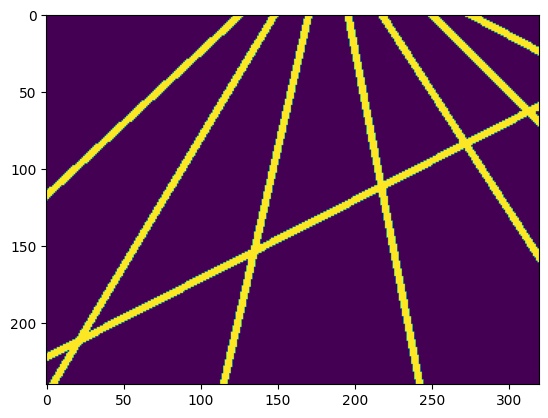

In [52]:
import cv2
import matplotlib.pyplot as plt
test = np.zeros((240,320))
print(tot)
for p1x,p1y,p2x,p2y in tot : 
    cv2.line(test, (p1x,p1y), (p2x,p2y), (255,0,0), 3)
plt.imshow(test)


In [53]:
tot

array([[ -582,  -832,   832,   582],
       [ -391,  -938,   697,   739],
       [  -63,  1011,   386,  -937],
       [ -822,  -583,   943,   355],
       [   -2, -1018,   379,   945],
       [ -406,   922,   623,  -791],
       [ -672,   744,   789,  -619],
       [ -801,   630,   980,  -277]])

In [54]:
import numpy as np

# NumPy array of size N x 4, where each row represents a line defined by two points (x1, y1, x2, y2)
lines = tot 

# Calculate the intersections of all the lines
intersections = []
for i in range(lines.shape[0]):
    for j in range(i + 1, lines.shape[0]):
        x1, y1, x2, y2 = lines[i]
        x3, y3, x4, y4 = lines[j]
        # Calculate the intersection of the two lines
        denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
        if denom != 0:  # Check if the lines are not parallel
            x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
            y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom
            intersections.append((x, y))

# Print the intersections
print(intersections)


[(157.61799660441426, -92.38200339558574), (185.00834376303712, -64.99165623696287), (221.63361547763, -28.366384522370012), (182.47914032869784, -67.52085967130215), (186.1816192560175, -63.818380743982495), (189.907223796034, -60.092776203966004), (312.7875744047619, 62.787574404761905), (182.48652014328104, -54.05064863944643), (187.31835537581708, -46.60304966429664), (186.2064507982659, -48.316895230981686), (181.35853464264133, -55.78928070247288), (182.84250812539204, -53.501942898637466), (271.82315700834994, 83.64929623437764), (181.48451384185344, -49.703414173564575), (183.90181112668031, -60.19093112421662), (183.83905436089222, -59.91865900894884), (182.22788346319518, -52.92854562651267), (134.6455141738879, 153.50899418544844), (186.4494678206311, -47.064815401840235), (178.61788997622503, -51.22686640356993), (179.75569560550755, -50.62218556489173), (353.8275349059571, 41.88738115682027), (183.92642615001236, -60.06410883865029), (184.83863882339813, -55.36417845057607

In [66]:
intersections = np.asarray(intersections).T
intersections[0]

array([ 157.6179966 ,  185.00834376,  221.63361548,  182.47914033,
        186.18161926,  189.9072238 ,  312.7875744 ,  182.48652014,
        187.31835538,  186.2064508 ,  181.35853464,  182.84250813,
        271.82315701,  181.48451384,  183.90181113,  183.83905436,
        182.22788346,  134.64551417,  186.44946782,  178.61788998,
        179.75569561,  353.82753491,  183.92642615,  184.83863882,
        217.21729222,  176.34108671,   20.80843097, -247.84884196])

In [73]:
intersections[1]

array([-92.3820034 , -64.99165624, -28.36638452, -67.52085967,
       -63.81838074, -60.0927762 ,  62.7875744 , -54.05064864,
       -46.60304966, -48.31689523, -55.7892807 , -53.5019429 ,
        83.64929623, -49.70341417, -60.19093112, -59.91865901,
       -52.92854563, 153.50899419, -47.0648154 , -51.2268664 ,
       -50.62218556,  41.88738116, -60.06410884, -55.36417845,
       111.45812238, -47.43661956, 211.48217468, 348.29977521])

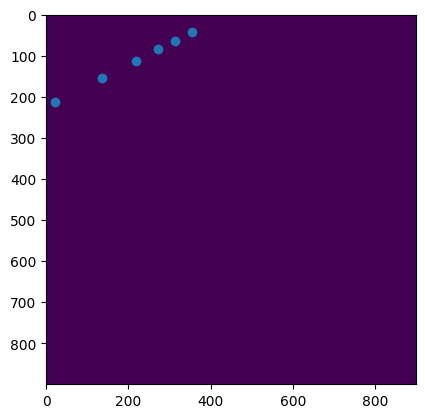

In [75]:
test = np.zeros((900,900))
plt.scatter(intersections[0], intersections[1])
plt.imshow(test)

In [78]:
intersections=intersections.T

In [79]:
intersections

array([[ 157.6179966 ,  -92.3820034 ],
       [ 185.00834376,  -64.99165624],
       [ 221.63361548,  -28.36638452],
       [ 182.47914033,  -67.52085967],
       [ 186.18161926,  -63.81838074],
       [ 189.9072238 ,  -60.0927762 ],
       [ 312.7875744 ,   62.7875744 ],
       [ 182.48652014,  -54.05064864],
       [ 187.31835538,  -46.60304966],
       [ 186.2064508 ,  -48.31689523],
       [ 181.35853464,  -55.7892807 ],
       [ 182.84250813,  -53.5019429 ],
       [ 271.82315701,   83.64929623],
       [ 181.48451384,  -49.70341417],
       [ 183.90181113,  -60.19093112],
       [ 183.83905436,  -59.91865901],
       [ 182.22788346,  -52.92854563],
       [ 134.64551417,  153.50899419],
       [ 186.44946782,  -47.0648154 ],
       [ 178.61788998,  -51.2268664 ],
       [ 179.75569561,  -50.62218556],
       [ 353.82753491,   41.88738116],
       [ 183.92642615,  -60.06410884],
       [ 184.83863882,  -55.36417845],
       [ 217.21729222,  111.45812238],
       [ 176.34108671,  -

In [80]:
import numpy as np

# NumPy array of points, where each row represents a point (x, y)
points = intersections

# Cluster the points that are close to each other
clusters = []
while points.shape[0] > 0:
    cluster = []
    x, y = points[0]
    cluster.append((x, y))
    points = points[1:]
    for i in range(points.shape[0] - 1, -1, -1):
        x2, y2 = points[i]
        # If the distance between the two points is less than 1, consider them part of the same cluster
        if abs(x - x2) < 1 and abs(y - y2) < 1:
            cluster.append((x2, y2))
            points = np.delete(points, i, axis=0)
    clusters.append(cluster)

# Find the main cluster
main_cluster = max(clusters, key=len)

# Print the main cluster
print(main_cluster)


[(183.90181112668031, -60.19093112421662), (183.92642615001236, -60.06410883865029), (183.83905436089222, -59.91865900894884)]


In [83]:
print(len(clusters))

24


In [85]:
tot

array([[ -582,  -832,   832,   582],
       [ -391,  -938,   697,   739],
       [  -63,  1011,   386,  -937],
       [ -822,  -583,   943,   355],
       [   -2, -1018,   379,   945],
       [ -406,   922,   623,  -791],
       [ -672,   744,   789,  -619],
       [ -801,   630,   980,  -277]])

In [86]:
import numpy as np

# List of lines, where each line is a tuple of two points (x1, y1, x2, y2)
lines = tot

# Calculate the intersections of all the lines
intersections = []
for i in range(len(lines)):
    for j in range(i + 1, len(lines)):
        x1, y1, x2, y2 = lines[i]
        x3, y3, x4, y4 = lines[j]
        # Calculate the intersection of the two lines
        denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
        if denom != 0:  # Check if the lines are not parallel
            x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
            y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom
            intersections.append((x, y))

# Cluster the intersections that are close to each other
clusters = []
while intersections:
    cluster = []
    x, y = intersections.pop()
    cluster.append((x, y))
    for i in range(len(intersections) - 1, -1, -1):
        x2, y2 = intersections[i]
        # If the distance between the two intersections is less than 0.1, consider them part of the same cluster
        if abs(x - x2) < 0.1 and abs(y - y2) < 0.1:
            cluster.append((x2, y2))
            intersections.pop(i)
    clusters.append(cluster)

# Find the main intersection cluster
main_cluster = max(clusters, key=len)

# Initialize a list to store the cleaned lines
cleaned_lines = []

# Iterate through the lines and keep only the ones that intersect the main intersection cluster
for line in lines:
    x1, y1, x2, y2 = line
    for x, y in main_cluster:
        # If the intersection lies on the line, keep it
        if (x1 <= x <= x2 or x2 <= x <= x1) and (y1 <= y <= y2 or y2 <= y <= y1):
            cleaned_lines.append(line)
            break

# Print the cleaned lines
print(cleaned_lines)



[array([-582, -832,  832,  582]), array([-391, -938,  697,  739]), array([-822, -583,  943,  355]), array([-406,  922,  623, -791]), array([-672,  744,  789, -619]), array([-801,  630,  980, -277])]


In [87]:
cleaned_lines

[array([-582, -832,  832,  582]),
 array([-391, -938,  697,  739]),
 array([-822, -583,  943,  355]),
 array([-406,  922,  623, -791]),
 array([-672,  744,  789, -619]),
 array([-801,  630,  980, -277])]

[[ -582  -832   832   582]
 [ -391  -938   697   739]
 [  -63  1011   386  -937]
 [ -822  -583   943   355]
 [   -2 -1018   379   945]
 [ -406   922   623  -791]
 [ -672   744   789  -619]
 [ -801   630   980  -277]]
-582
-391
-822
-406
-672
-801


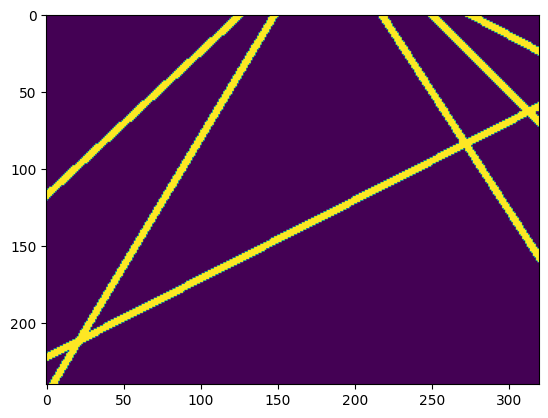

In [89]:
import cv2
import matplotlib.pyplot as plt
test = np.zeros((240,320))
print(tot)
for p1x,p1y,p2x,p2y in cleaned_lines : 
    print(p1x)
    cv2.line(test, (p1x,p1y), (p2x,p2y), (255,0,0), 3)
plt.imshow(test)

In [90]:
tot

array([[ -582,  -832,   832,   582],
       [ -391,  -938,   697,   739],
       [  -63,  1011,   386,  -937],
       [ -822,  -583,   943,   355],
       [   -2, -1018,   379,   945],
       [ -406,   922,   623,  -791],
       [ -672,   744,   789,  -619],
       [ -801,   630,   980,  -277]])

In [91]:
import numpy as np

# NumPy array of lines, where each row represents a line defined by two points (x1, y1, x2, y2)
lines = tot

# Given point
point = (193, -35)

# Initialize a variable to store the farthest distance
farthest_distance = 0

# Iterate through the lines and find the farthest one from the given point
for line in lines:
    x1, y1, x2, y2 = line
    # Calculate the distance from the point to the line
    distance = abs((y2 - y1) * point[0] - (x2 - x1) * point[1] + x2 * y1 - y2 * x1) / np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    if distance > farthest_distance:
        farthest_distance = distance
        farthest_line = line

# Print the farthest


In [92]:
farthest_line

array([-801,  630,  980, -277])

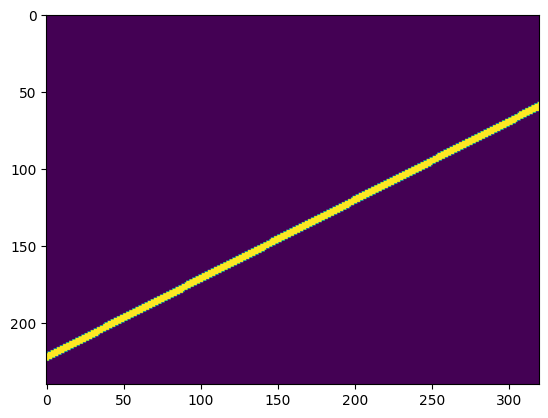

In [94]:
import cv2
import matplotlib.pyplot as plt
test = np.zeros((240,320))
p1x,p1y,p2x,p2y = farthest_line 
cv2.line(test, (p1x,p1y), (p2x,p2y), (255,0,0), 3)
plt.imshow(test)